In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode
from torch.utils.data import DataLoader

In [2]:
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/Users/david/Desktop/shelter_dogs_research/Data/trial2_env1/inpainted'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=8)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

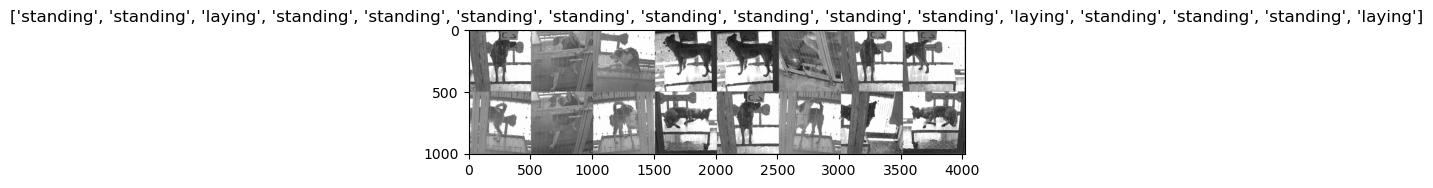

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    #self code
    ds_train_acc = {}
    ds_train_loss = {}
    ds_val_acc = {}
    ds_val_loss = {}
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                #self code
                if phase == 'train':
                    train_loss = epoch_loss
                    train_acc = epoch_acc
                    ds_train_acc[epoch] = train_acc
                    ds_train_loss[epoch] = train_loss
                else:
                    val_loss = epoch_loss
                    val_acc = epoch_acc
                    ds_val_acc[epoch] = val_acc    
                    ds_val_loss[epoch] = val_loss               

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')
        
        libs = (ds_train_acc, ds_train_loss, ds_val_acc, ds_val_loss)  
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, libs

In [6]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [7]:
model_ft, libs = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.6245 Acc: 0.6761
val Loss: 0.5302 Acc: 0.6875

Epoch 1/4
----------
train Loss: 0.5318 Acc: 0.7606
val Loss: 0.4513 Acc: 0.9375

Epoch 2/4
----------
train Loss: 0.3788 Acc: 0.8592
val Loss: 0.3158 Acc: 0.9375

Epoch 3/4
----------
train Loss: 0.2389 Acc: 0.9718
val Loss: 0.1990 Acc: 1.0000

Epoch 4/4
----------
train Loss: 0.1549 Acc: 1.0000
val Loss: 0.1111 Acc: 1.0000

Training complete in 4m 37s
Best val Acc: 1.000000


In [8]:
def visualize_train(model_ft, libs):
    ds_train_acc, ds_train_loss, ds_val_acc, ds_val_loss = libs
    #initialize the figure
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    #plot the training accuracy in blue
    axs[0].plot(ds_train_acc.keys(), ds_train_acc.values(), 'b-')
    #plot the validation accuracy in a new color on the same graph
    axs[0].plot(ds_val_acc.keys(), ds_val_acc.values(), 'r-')
    axs[0].set_title("Accuracy")
    #set the legend and labels
    axs[0].legend(['Training Accuracy', 'Validation Accuracy'])
    #set the labels
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    #plot the training loss in blue
    axs[1].plot(ds_train_loss.keys(), ds_train_loss.values(), 'b-')
    #plot the validation loss in a new color on the same graph
    axs[1].plot(ds_val_loss.keys(), ds_val_loss.values(), 'r-')
    axs[1].set_title("Loss")
    #set the legend and labels
    axs[1].legend(['Training Loss', 'Validation Loss'])
    #set the labels
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    plt.show()
    return fig 


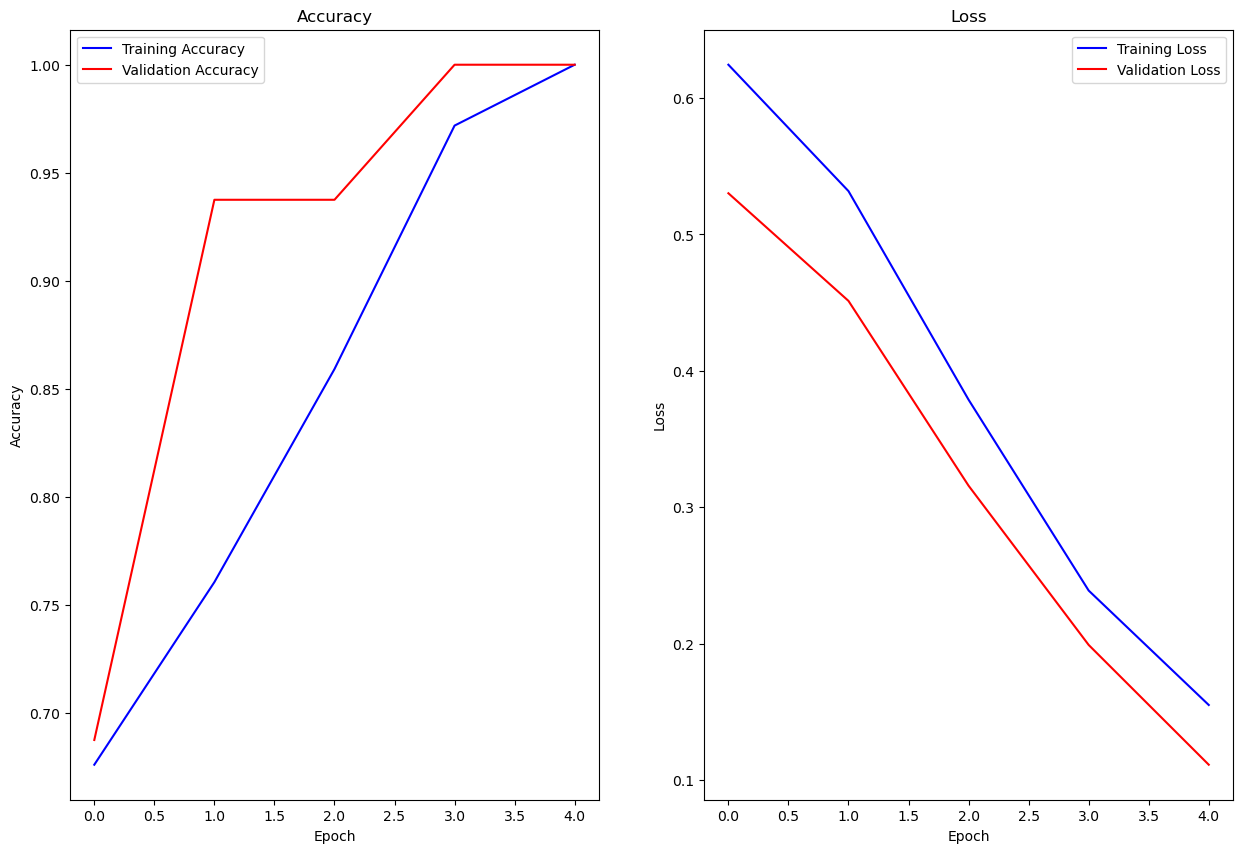

In [9]:
fig = visualize_train(model_ft, libs)

In [10]:
#fuction for exporting of model
def export_model(model, fig, model_dir):
    model_scripted = torch.jit.script(model)
    model_scripted.save(model_dir + '.pt')
    print(f"model exported to {model_dir}")
    #export figure as jpg
    fig.savefig(model_dir + '.jpg')
    print(f"figure exported to {model_dir + '.jpg'}")
export_model(model_ft, fig, '/Users/david/Desktop/shelter_dogs_research/Data/trial2_env1/trial2.0_docs/model ')

model exported to /Users/david/Desktop/shelter_dogs_research/Data/trial2_env1/trial2.0_docs/model 
figure exported to /Users/david/Desktop/shelter_dogs_research/Data/trial2_env1/trial2.0_docs/model .jpg
